In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import re
import os
import glob
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [7]:
path_1 = r"C:\GitHub\Analysis\kkk\taisen.txt"
path_3 = r"C:\GitHub\Analysis\kkk\taisen copy 2.txt"
path_4= r"C:\GitHub\Analysis\kkk\taisen copy 3.txt"
path_5 = r"C:\GitHub\Analysis\kkk\taisen copy 4.txt"
path_6 = r"C:\GitHub\Analysis\kkk\taisen copy 5.txt"
path_2 = r"C:\GitHub\Analysis\kkk\taisen copy.txt"

In [8]:
df_1 = pd.read_csv(path_1 , on_bad_lines='skip')
df_2 = pd.read_csv(path_2 , on_bad_lines='skip')
df_3 = pd.read_csv(path_3 , on_bad_lines='skip')
df_4 = pd.read_csv(path_4 , on_bad_lines='skip')
df_5 = pd.read_csv(path_5 , on_bad_lines='skip')
df_6 = pd.read_csv(path_6 , on_bad_lines='skip')

In [10]:
# 各データフレームの列数を表示して確認する
dfs = {"df_1": df_1, "df_2": df_2, "df_3": df_3, "df_4": df_4, "df_5": df_5, "df_6": df_6}

for name, df in dfs.items():
    print(f"{name}: {len(df.columns)} columns")

df_1: 4 columns
df_2: 3 columns
df_3: 3 columns
df_4: 3 columns
df_5: 3 columns
df_6: 3 columns


In [11]:
print(df_1.columns)
print(df_2.columns)
print(df_3.columns)
print(df_4.columns)
print(df_5.columns)
print(df_6.columns)

Index(['[con1] Timestamp: 2025-12-23 13:55:54.760588', ' Code: LeftArrow',
       ' State: (x=-1', ' y=0)'],
      dtype='object')
Index(['[con1] Timestamp: 2025-12-23 14:11:38.713709', ' Code: A',
       ' State: 1'],
      dtype='object')
Index(['[con1] Timestamp: 2025-12-23 14:23:21.647499', ' Code: A',
       ' State: 1'],
      dtype='object')
Index(['[con1] Timestamp: 2025-12-23 14:21:42.103649', ' Code: A',
       ' State: 1'],
      dtype='object')
Index(['[con1] Timestamp: 2025-12-23 14:27:52.652544', ' Code: A',
       ' State: 1'],
      dtype='object')
Index(['[con1] Timestamp: 2025-12-23 14:26:28.303735', ' Code: A',
       ' State: 1'],
      dtype='object')


In [12]:
def clean_and_unify_df(df):
    """
    4列の場合は後ろ2列を結合し、全てのDFを3列に統一。
    ヘッダー行の追加をpd.concatで行うことでインデックスエラーを回避する。
    """
    temp_df = df.copy()
    orig_cols = temp_df.columns.tolist()

    # 1. カラムの統一 (4列を3列にする)
    if len(orig_cols) == 4:
        # 一時的な名前を付けて操作
        temp_df.columns = ['ts', 'cd', 'sx', 'sy']
        # state_x と state_y を文字列として結合
        temp_df['state'] = temp_df['sx'].astype(str) + "," + temp_df['sy'].astype(str)
        temp_df = temp_df[['ts', 'cd', 'state']]
        # 挿入用のヘッダー行も結合して作成
        header_row = [orig_cols[0], orig_cols[1], f"{orig_cols[2]},{orig_cols[3]}"]
    else:
        # 3列の場合はそのまま
        header_row = orig_cols

    # 2. 新しい列名を設定
    temp_df.columns = ['[con]timestamp', 'code', 'state']

    # 3. ヘッダーを「データ」として1行目に挿入 (インデックス計算を使わない安全な方法)
    header_df = pd.DataFrame([header_row], columns=temp_df.columns)
    temp_df = pd.concat([header_df, temp_df], ignore_index=True)

    # 4. 指定された行の削除 (元のコードのロジックを継承)
    # これにより、追加したヘッダーとデータの最初の2行が削除されます
    if len(temp_df) > 2:
        temp_df = temp_df.drop([0, 1]).reset_index(drop=True)
    if len(temp_df) > 0:
        temp_df = temp_df.drop([0]).reset_index(drop=True)
    
    return temp_df



In [13]:
# --- 実行コード ---
target_dfs = [df_1, df_2, df_3, df_4, df_5, df_6]
processed = [clean_and_unify_df(df) for df in target_dfs]

# 各変数に上書き保存
df_1, df_2, df_3, df_4, df_5, df_6 = processed

In [14]:
def split_timestamp_column(df):
    """
    '[con]timestamp' 列を 'controller' と 'timestamp' に分割する
    """
    # 正規表現を使用して、[]の中身と Timestamp: 以降の文字列を抽出
    # [con1] Timestamp: 2025-12-23 ... -> 'con1' と '2025-12-23 ...'
    extracted = df['[con]timestamp'].str.extract(r'\[(?P<controller>.*?)\] Timestamp: (?P<timestamp>.*)')
    
    # 抽出した列を元のデータフレームの先頭に結合し、元の列を削除
    new_df = pd.concat([extracted, df.drop(columns=['[con]timestamp'])], axis=1)
    
    return new_df

In [15]:
# 全てのデータフレームに対して実行
target_dfs = [df_1, df_2, df_3, df_4, df_5, df_6]
processed_v2 = [split_timestamp_column(df) for df in target_dfs]

# 各変数に上書き保存
df_1, df_2, df_3, df_4, df_5, df_6 = processed_v2

In [16]:
# 1. ユーザー名のマッピング定義
user_mappings = [
    {"con1": "kota", "con2": "JIN"},    # df_1
    {"con1": "kota", "con2": "JIN"},    # df_2
    {"con1": "Keita", "con2": "JIN"},   # df_3
    {"con1": "Keita", "con2": "JIN"},   # df_4
    {"con1": "kota", "con2": "Keita"},  # df_5
    {"con1": "kota", "con2": "Keita"}   # df_6
]

# 2. 各試合の勝者（名前）の定義
# 判定用に小文字に統一したリストを作成
match_winners = ["kota", "jin", "keita", "jin", "keita", "keita"]

# 3. データフレームのリスト
target_dfs = [df_1, df_2, df_3, df_4, df_5, df_6]

# 4. 各データフレームに列を追加
for i, df in enumerate(target_dfs):
    # 'user'列を追加
    mapping = user_mappings[i]
    df['user'] = df['controller'].map(mapping)
    
    # 'winner'列を追加: ユーザー名が勝者名と一致すれば 'win'、そうでなければ 'lose'
    # .str.lower() を使って大文字小文字の差を無視して判定
    winner_name = match_winners[i]
    df['winner'] = df['user'].apply(lambda x: 'win' if str(x).lower() == winner_name else 'lose')

In [39]:
# 削除したい値のリスト
remove_list = [' Code: Right', ' Code: Left', ' Code: Up', ' Code: Down', ' Code: Center']

# 指定した値を含まない行だけを抽出（結果として削除と同じになる）
df_1 = df_1[~df_1['code'].isin(remove_list)]
df_2 = df_2[~df_2['code'].isin(remove_list)]
df_3 = df_3[~df_3['code'].isin(remove_list)]
df_4 = df_4[~df_4['code'].isin(remove_list)]
df_5 = df_5[~df_5['code'].isin(remove_list)]
df_6 = df_6[~df_6['code'].isin(remove_list)]


In [40]:
# 確認
print("df_1のカラム:", df_1.columns.tolist())
print("df_2のカラム:", df_2.columns.tolist())
print("df_3のカラム:", df_2.columns.tolist())
print("df_4のカラム:", df_2.columns.tolist())
print("df_5のカラム:", df_2.columns.tolist())
print("df_6のカラム:", df_6.columns.tolist())
df_1.head()

df_1のカラム: ['controller', 'timestamp', 'code', 'state', 'user', 'winner']
df_2のカラム: ['controller', 'timestamp', 'code', 'state', 'user', 'winner']
df_3のカラム: ['controller', 'timestamp', 'code', 'state', 'user', 'winner']
df_4のカラム: ['controller', 'timestamp', 'code', 'state', 'user', 'winner']
df_5のカラム: ['controller', 'timestamp', 'code', 'state', 'user', 'winner']
df_6のカラム: ['controller', 'timestamp', 'code', 'state', 'user', 'winner']


,controller,timestamp,code,state,user,winner
0,con1,2025-12-23 13:55:54.830497,Code: DownLeft,"State: (x=-1, y=1)",kota,win
1,con1,2025-12-23 13:55:54.830497,Code: DownArrow,"State: (x=0, y=1)",kota,win
2,con1,2025-12-23 13:55:54.832497,Code: DownLeft,"State: (x=-1, y=1)",kota,win
3,con1,2025-12-23 13:55:54.842505,Code: LeftArrow,"State: (x=-1, y=0)",kota,win
4,con2,2025-12-23 13:55:55.352732,Code: UpLeft,"State: (x=-1, y=-1)",JIN,lose


In [41]:
df_1["code"].unique()

array([' Code: DownLeft', ' Code: DownArrow', ' Code: LeftArrow',
       ' Code: UpLeft', ' Code: UpArrow', ' Code: DownRight',
       ' Code: RightArrow', ' Code: UpRight', ' Code: Y', ' Code: RB',
       ' Code: A', ' Code: ABS_RZ', ' Code: X', nan, ' Code: B',
       ' Code: ABS_Z'], dtype=object)

In [42]:
df_1.groupby('user')['code'].size()

user
JIN     430
kota    549
Name: code, dtype: int64

In [47]:
# kotaとjinの2人を抽出して集計する
# 1. ユーザーをkotaとjinに絞り込む
target_users = ['kota', 'JIN']
df_filtered = df_1[df_1['user'].isin(target_users)]

# 2. userとcodeでグループ化して個数を数える（クロス集計）
# pivot_tableを使うと、比較しやすい表形式になります
comparison_df = df_filtered.pivot_table(
    index='code', 
    columns='user', 
    aggfunc='size', 
    fill_value=0
).reset_index()

comparison_df

user,code,JIN,kota
0,Code: A,18,26
1,Code: ABS_RZ,8,33
2,Code: ABS_Z,2,0
3,Code: B,6,0
4,Code: DownArrow,60,100
5,Code: DownLeft,36,83
6,Code: DownRight,53,66
7,Code: LeftArrow,54,85
8,Code: RB,15,30
9,Code: RightArrow,73,49


In [50]:
# 1. データの統合
target_dfs = [df_1, df_2, df_3, df_4, df_5, df_6]
all_df = pd.concat(target_dfs, ignore_index=True)

In [51]:
all_df.head()

,controller,timestamp,code,state,user,winner
0,con1,2025-12-23 13:55:54.830497,Code: DownLeft,"State: (x=-1, y=1)",kota,win
1,con1,2025-12-23 13:55:54.830497,Code: DownArrow,"State: (x=0, y=1)",kota,win
2,con1,2025-12-23 13:55:54.832497,Code: DownLeft,"State: (x=-1, y=1)",kota,win
3,con1,2025-12-23 13:55:54.842505,Code: LeftArrow,"State: (x=-1, y=0)",kota,win
4,con2,2025-12-23 13:55:55.352732,Code: UpLeft,"State: (x=-1, y=-1)",JIN,lose


In [52]:
# codeの欠損値削除と文字列整形
all_df = all_df.dropna(subset=['code', 'user'])
all_df['code'] = all_df['code'].str.strip()

In [54]:
all_df.head()

,controller,timestamp,code,state,user,winner
0,con1,2025-12-23 13:55:54.830497,Code: DownLeft,"State: (x=-1, y=1)",kota,win
1,con1,2025-12-23 13:55:54.830497,Code: DownArrow,"State: (x=0, y=1)",kota,win
2,con1,2025-12-23 13:55:54.832497,Code: DownLeft,"State: (x=-1, y=1)",kota,win
3,con1,2025-12-23 13:55:54.842505,Code: LeftArrow,"State: (x=-1, y=0)",kota,win
4,con2,2025-12-23 13:55:55.352732,Code: UpLeft,"State: (x=-1, y=-1)",JIN,lose


In [55]:
one_hot = pd.get_dummies(all_df['code'], prefix='feat')
temp_df = pd.concat([all_df[['user']], one_hot], axis=1)

In [64]:
one_hot.head()

,feat_Code: A,feat_Code: ABS_RZ,feat_Code: ABS_Z,feat_Code: B,feat_Code: DownArrow,feat_Code: DownLeft,feat_Code: DownRight,feat_Code: LeftArrow,feat_Code: RB,feat_Code: RightArrow,feat_Code: UpArrow,feat_Code: UpLeft,feat_Code: UpRight,feat_Code: X,feat_Code: Y
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [65]:
temp_df.head()

,user,feat_Code: A,feat_Code: ABS_RZ,feat_Code: ABS_Z,feat_Code: B,feat_Code: DownArrow,feat_Code: DownLeft,feat_Code: DownRight,feat_Code: LeftArrow,feat_Code: RB,feat_Code: RightArrow,feat_Code: UpArrow,feat_Code: UpLeft,feat_Code: UpRight,feat_Code: X,feat_Code: Y
0,kota,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,kota,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,kota,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,kota,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
4,JIN,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [70]:
temp_df.columns

Index(['user', 'feat_Code: A', 'feat_Code: ABS_RZ', 'feat_Code: ABS_Z',
       'feat_Code: B', 'feat_Code: DownArrow', 'feat_Code: DownLeft',
       'feat_Code: DownRight', 'feat_Code: LeftArrow', 'feat_Code: RB',
       'feat_Code: RightArrow', 'feat_Code: UpArrow', 'feat_Code: UpLeft',
       'feat_Code: UpRight', 'feat_Code: X', 'feat_Code: Y'],
      dtype='object')

In [66]:
window_size = 50
rolling_features = one_hot.rolling(window=window_size).sum().fillna(0)
rolling_features.columns = [f"{col}_freq" for col in rolling_features.columns]

In [72]:
X = temp_df[['feat_Code: A', 'feat_Code: ABS_RZ', 'feat_Code: ABS_Z',
       'feat_Code: B', 'feat_Code: DownArrow', 'feat_Code: DownLeft',
       'feat_Code: DownRight', 'feat_Code: LeftArrow', 'feat_Code: RB',
       'feat_Code: RightArrow', 'feat_Code: UpArrow', 'feat_Code: UpLeft',
       'feat_Code: UpRight', 'feat_Code: X', 'feat_Code: Y']]
y = temp_df['user']

In [82]:
X = rolling_features.copy()
X.columns = [col.replace(':', '').replace(' ', '_') for col in X.columns]

In [83]:
# ユーザー名を数値に変換 (kota=0, JIN=1, Keita=2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [84]:
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 5. LightGBMモデルの構築
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [85]:
params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42
}

# 学習
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	training's multi_logloss: 0.520323	valid_1's multi_logloss: 0.729974


<Figure size 1000x600 with 0 Axes>

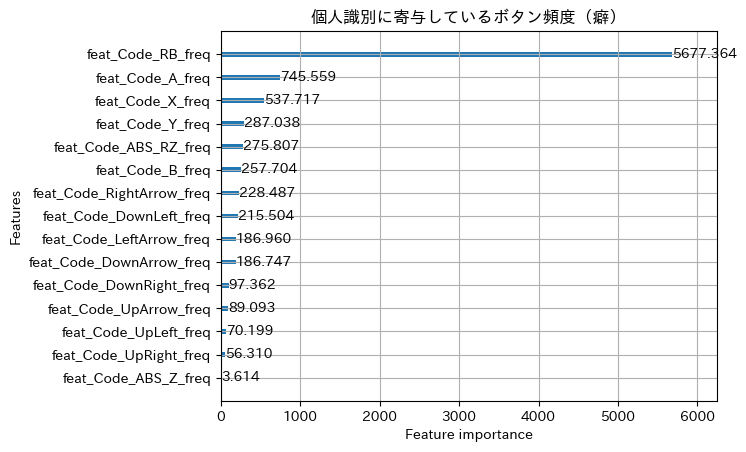

In [86]:
# 6. 結果の可視化：特徴量重要度（これが「個人パターン」の正体）
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.title('個人識別に寄与しているボタン頻度（癖）')
plt.show()

In [87]:
# 精度確認
y_pred = model.predict(X_test)
y_pred_max = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_max, target_names=le.classes_))

              precision    recall  f1-score   support

         JIN       0.48      0.40      0.44        97
       Keita       0.63      0.90      0.74       109
        kota       0.65      0.53      0.59       169

    accuracy                           0.61       375
   macro avg       0.59      0.61      0.59       375
weighted avg       0.60      0.61      0.59       375

